<a href="https://colab.research.google.com/github/Psousace/Diversos/blob/main/1_An%C3%A1lise_Carteira_vs_CDI_e_outros_benchmarks_ORIGINA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparação e carteira com o CDI e outros benchmarks

A intenção deste código é servir como um framework de comparação de uma carteira fictícia com um CDB também fictício que rende 100% do CDI.

Este código foi publicado no Instagram da Trading com Dados.
Link para a publicação: https://www.instagram.com/p/CUORUv2t1hu/.

IMPORTANTE: Este código NÃO segue com rigor matemático a metodologia do cálculo acumulado de DI como designada pela B3. A fórmula matemática para esse cálculo é um pouco complexa e não caberia aqui no nosso tutorial. Para fins de simplificação, 'enxugamos' o cálculo da taxa diária e dos valores acumulados. Note, no entanto, que ao fim da rotina os valores de rendimento do CDI são bem próximos àqueles estipulados pela B3.

## 1. Instalando e importando bibliotecas

Nesse tutorial usarei a biblioteca yfinance para obter os dados de ativos brasileiros e a Quandl para obter a taxa DI (depósito interbancário), que determina o CDI. Fique a vontade para colocar outras bibliotecas e adicionar outros tipos de ativos.

In [1]:
!pip install yfinance
!pip install quandl
!pip install matplotlib
!pip install sgs
!pip install python-bcb
!pip install yfinance --upgrade --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 9.3 MB/s eta 0:00:00
  Installing build

Após a instalação, importe essas e outras bibliotecas mostradas a seguir:

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from bcb import sgs
import pandas_datareader.data as web
import seaborn as sns
sns.set()

## 2. Importando dados

Para simplificar a análise, vou colocar apenas ações brasileiras e simular uma única compra, sem aportes posteriores. No fim vou também incluir o IBOV e dólar para fins de comparação. Trata-se de uma carteira aleatória, não usei nenhuma metodologia para escolher essas ações.

Não esqueça de colocar o ".SA" para ativos brasileiros.

In [3]:
ativos = ['ITUB4.SA', 'PETR4.SA', 'VALE3.SA','BBAS3.SA',
          'ABEV3.SA', 'CIEL3.SA', 'EZTC3.SA', 'ECOR3.SA',
          'WEGE3.SA', 'RADL3.SA', 'OIBR3.SA']

In [4]:
inicio = '2012-01-01'
fim = '2021-09-24'

Utilize o seguinte loop abaixo para extrair os preços de fechamento de todos esses papéis de uma só vez, para um intervalo específico.

In [5]:
precos = pd.DataFrame()

for i in ativos:
  precos[i] = yf.download(i, start = inicio, end = fim)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 3. Simulação a criação de uma carteira

Criando um dicionário com as alocações que vamos fazer para cada ativo na nossa carteira

A carteira terá um valor investido total de R$ 20 mil, distibuídos nos seguintes ativos

In [6]:
compras = {'ITUB4.SA':6000, 'PETR4.SA':4000, 'VALE3.SA':3000,
           'BBAS3.SA':2000, 'ABEV3.SA':2000, 'CIEL3.SA':1000,
           'EZTC3.SA': 800, 'ECOR3.SA':600 , 'WEGE3.SA':400,
           'RADL3.SA':100, 'OIBR3.SA':100}

compras_df = pd.Series(data=compras, index=list(compras.keys()))

Para facilitar, estou assumindo que fiz todos os aportes no primeiro dia de investimento (01/01/12), e depois não fiz mais nenhum aporte. Aqui estou assumindo um total investido de R$ 20 mil, alocado de diferentes formas entre os ativos.

Qual o valor total da nossa carteira?

In [7]:
sum(compras.values())

20000

Vamos calcular agora o número de papéis que compramos de cada ativo. Primeiramente, precisamos do preço de cada ativo no dia que realizamos a compra:

In [8]:
primeiro = precos.iloc[0]

Quantidade de papéis comprados de cada ativo

In [9]:
qtd_acoes = compras_df/primeiro

Criando um dataframe que contém a posição diária de cada ativo

In [10]:
PL = precos*qtd_acoes

In [ ]:
PL.head()

,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA
Date,,,,,,,,,,,
2012-01-02,6000.000000,4000.000000,3000.000000,2000.000000,2000.000000,1000.000000,800.000000,600.000000,400.000000,100.000000,100.000000
2012-01-03,6149.863133,4159.107643,3133.496347,1990.942072,1977.206217,1003.723041,824.844691,599.552970,409.431655,101.515154,102.416686
2012-01-04,6156.917429,4188.803074,3154.767090,1981.061341,1931.250587,1007.238847,831.304054,590.611147,411.575448,101.515154,102.166672
2012-01-05,6111.074153,4140.547767,3070.415746,1960.476498,1893.015001,992.761224,797.515526,581.669133,414.147714,100.757612,100.333340
2012-01-06,6156.917429,4144.260849,3044.009222,1911.073714,1888.235797,986.556701,801.490465,571.385899,409.431655,100.378781,101.583341


Vamos remover os NaNs que surgem e eventualmente podem atrapalhar a consolidação da nossa carteira

In [11]:
PL_filter = PL.dropna(axis='rows')

In [12]:
PL_filter.head(3)

,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA
Date,,,,,,,,,,,
2012-01-02,6000.000000,4000.000000,3000.000000,2000.000000,2000.000000,1000.000000,800.000000,600.000000,400.000000,100.000000,100.000000
2012-01-03,6149.871418,4159.107004,3133.495684,1990.943035,1977.205602,1003.723156,824.844609,599.552955,409.431827,101.515169,102.416660
2012-01-04,6156.923523,4188.802743,3154.766564,1981.062818,1931.250266,1007.238842,831.304266,590.611089,411.575449,101.515169,102.166661


In [13]:
PL_filter.tail()

,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA
Date,,,,,,,,,,,
2021-09-17,16078.111229,6028.800038,9647.462254,4398.202237,4043.095084,366.513636,2671.959056,647.749981,6892.085655,1092.992306,1.361218
2021-09-20,15714.013257,5961.087064,9266.716048,4255.344512,4009.702081,347.145020,2654.159940,626.247899,6839.327243,1078.036886,1.375397
2021-09-21,15673.558731,6096.511359,9420.134308,4363.247666,4022.545750,344.165268,2705.463164,641.030564,6990.569365,1065.573867,1.347038
2021-09-22,16037.651874,6251.283240,9754.967450,4465.072621,4037.957885,370.983296,2771.424211,661.860762,7134.777680,1051.033903,1.375397
2021-09-23,16592.466969,6490.693722,9754.626837,4475.710998,4079.056554,365.023749,2627.984533,665.892322,7240.295891,1057.265412,1.460473


Vamos criar uma nova variável 'PL Total' que vai representar o total do nosso PL diário. Essa coluna será simplesmente a soma de todas as posições:

In [14]:
PL_filter['PL Total'] = PL_filter.iloc[:].sum(axis = 1)

In [ ]:
PL_filter.head()

,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA,PL Total
Date,,,,,,,,,,,,
2012-01-02,6000.000000,4000.000000,3000.000000,2000.000000,2000.000000,1000.000000,800.000000,600.000000,400.000000,100.000000,100.000000,20000.000000
2012-01-03,6149.863133,4159.107643,3133.496347,1990.942072,1977.206217,1003.723041,824.844691,599.552970,409.431655,101.515154,102.416686,20452.099608
2012-01-04,6156.917429,4188.803074,3154.767090,1981.061341,1931.250587,1007.238847,831.304054,590.611147,411.575448,101.515154,102.166672,20457.210843
2012-01-05,6111.074153,4140.547767,3070.415746,1960.476498,1893.015001,992.761224,797.515526,581.669133,414.147714,100.757612,100.333340,20162.713713
2012-01-06,6156.917429,4144.260849,3044.009222,1911.073714,1888.235797,986.556701,801.490465,571.385899,409.431655,100.378781,101.583341,20115.323854


Sucesso! Perceba que nosso patrimônio líquido (PL) está somando R$ 20 mil no primeiro dia.

In [15]:
PL_filter.tail()

,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA,PL Total
Date,,,,,,,,,,,,
2021-09-17,16078.111229,6028.800038,9647.462254,4398.202237,4043.095084,366.513636,2671.959056,647.749981,6892.085655,1092.992306,1.361218,51868.332694
2021-09-20,15714.013257,5961.087064,9266.716048,4255.344512,4009.702081,347.145020,2654.159940,626.247899,6839.327243,1078.036886,1.375397,50753.155346
2021-09-21,15673.558731,6096.511359,9420.134308,4363.247666,4022.545750,344.165268,2705.463164,641.030564,6990.569365,1065.573867,1.347038,51324.147080
2021-09-22,16037.651874,6251.283240,9754.967450,4465.072621,4037.957885,370.983296,2771.424211,661.860762,7134.777680,1051.033903,1.375397,52538.388319
2021-09-23,16592.466969,6490.693722,9754.626837,4475.710998,4079.056554,365.023749,2627.984533,665.892322,7240.295891,1057.265412,1.460473,53350.477461


## 4. Dados do CDI para comparação

Vamos agora usar a Quandl para extrair a taxa DI diária. Para usá-la, você precisa ter uma conta e obter uma chave de API. Se você não tem conta ainda, confira o nosso conteúdo sobre como usar a Quandl.

Obtendo dados do CDI para comparar com a nossa carteira

In [18]:
# quandl.ApiConfig.api_key = "SUACHAVEAQUI"

Dentro da Quandl, vamos buscar a tabela de número 1161, que segundo o próprio Banco Central é a <i>"Taxa média flutuante DI de depósitos a prazo (CDB/RDB) - Instituições financeiras"</i>:

In [20]:
# cdi = quandl.get("BCB/1161", start_date = inicio)
cdi = sgs.get({'CDI':1161}, start='2012-01-01', end= '2021-09-04')
cdi

,CDI
Date,
2011-12-30,0.0400
2012-01-02,0.0399
2012-01-03,0.0378
2012-01-04,0.0390
2012-01-05,0.0384
...,...
2021-08-30,0.0201
2021-08-31,0.0201
2021-09-01,0.0215


In [21]:
cdi.head()

,CDI
Date,
2011-12-30,0.0400
2012-01-02,0.0399
2012-01-03,0.0378
2012-01-04,0.0390
2012-01-05,0.0384


In [22]:
cdi.rename(columns = {'Value': 'CDI'}, inplace = True)

In [23]:
cdi = cdi[~(cdi == 0).any(axis=1)]

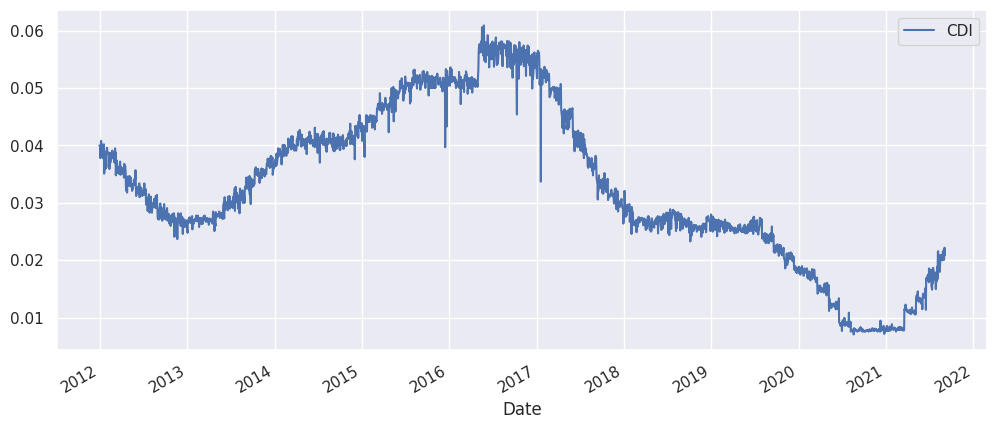

In [25]:
cdi.plot(figsize=(12,5))
plt.show()

Verificando se o índice dos dataframes está no formato 'data'

In [26]:
cdi.index = pd.to_datetime(cdi.index)

In [27]:
PL_filter.index = pd.to_datetime(PL_filter.index)

In [28]:
PL_filter.head()

,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA,PL Total
Date,,,,,,,,,,,,
2012-01-02,6000.000000,4000.000000,3000.000000,2000.000000,2000.000000,1000.000000,800.000000,600.000000,400.000000,100.000000,100.000000,20000.000000
2012-01-03,6149.871418,4159.107004,3133.495684,1990.943035,1977.205602,1003.723156,824.844609,599.552955,409.431827,101.515169,102.416660,20452.107118
2012-01-04,6156.923523,4188.802743,3154.766564,1981.062818,1931.250266,1007.238842,831.304266,590.611089,411.575449,101.515169,102.166661,20457.217390
2012-01-05,6111.080614,4140.548923,3070.415141,1960.477092,1893.014395,992.761414,797.515476,581.669223,414.147935,100.757537,100.333332,20162.721083
2012-01-06,6156.923523,4144.260649,3044.009769,1911.074647,1888.235028,986.556839,801.490451,571.385965,409.431827,100.378721,101.583329,20115.330748


## 5. Consolidação de benchmarks

Voltando agora para a biblioteca yfinance, vou baixar também os dados de IBOV e dólar, para usar como benchmark:

In [29]:
benckhmarks = ['^BVSP', 'USDBRL=X']

benchs = pd.DataFrame()

for i in benckhmarks:
  benchs[i] = yf.download(i, start = inicio, end = fim)['Adj Close']

benchs = pd.merge(benchs, cdi, how = 'inner', on = 'Date')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [30]:
benchs.head()

,^BVSP,USDBRL=X,CDI
Date,,,
2012-01-03,59265.0,1.8701,0.0378
2012-01-04,59365.0,1.8345,0.0390
2012-01-05,58546.0,1.8184,0.0384
2012-01-06,58600.0,1.8430,0.0408
2012-01-09,59083.0,1.8476,0.0401


Juntando tudo num dataframe só

In [31]:
novo_df = pd.merge(benchs, PL_filter, how = 'inner', on = 'Date')

In [32]:
novo_df.head()

,^BVSP,USDBRL=X,CDI,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA,PL Total
Date,,,,,,,,,,,,,,,
2012-01-03,59265.0,1.8701,0.0378,6149.871418,4159.107004,3133.495684,1990.943035,1977.205602,1003.723156,824.844609,599.552955,409.431827,101.515169,102.416660,20452.107118
2012-01-04,59365.0,1.8345,0.0390,6156.923523,4188.802743,3154.766564,1981.062818,1931.250266,1007.238842,831.304266,590.611089,411.575449,101.515169,102.166661,20457.217390
2012-01-05,58546.0,1.8184,0.0384,6111.080614,4140.548923,3070.415141,1960.477092,1893.014395,992.761414,797.515476,581.669223,414.147935,100.757537,100.333332,20162.721083
2012-01-06,58600.0,1.8430,0.0408,6156.923523,4144.260649,3044.009769,1911.074647,1888.235028,986.556839,801.490451,571.385965,409.431827,100.378721,101.583329,20115.330748
2012-01-09,59083.0,1.8476,0.0401,6195.709497,4199.936545,3040.341654,1926.719499,1884.558499,990.486352,811.925452,588.822780,409.431827,100.757537,101.666662,20250.356303


In [33]:
len(novo_df)

2391

In [34]:
novo_df.CDI.iloc[1]

0.039

In [35]:
novo_df.CDI

Date
2012-01-03    0.0378
2012-01-04    0.0390
2012-01-05    0.0384
2012-01-06    0.0408
2012-01-09    0.0401
               ...  
2021-08-30    0.0201
2021-08-31    0.0201
2021-09-01    0.0215
2021-09-02    0.0222
2021-09-03    0.0209
Name: CDI, Length: 2391, dtype: float64

## 6. Criação de CDB fictício

Os dados do CDI que você baixou são referentes à uma taxa diária, e não uma cota ou preço de ativo. Se quisermos comparar o CDI de igual para igual com o preço de uma ação ou 'cota' de uma carteira, precisamos transformar esses dados do CDI também em um investimento fictício. Para isso, vou simular a criação de um CDB que rende 100% do CDI. O racional é simples: simulo que tenho R$ 1,00 no primeiro dia e esse investimento evolui diariamente de acordo com a oscilação da taxa DI (como um CDB real).


Como implementar isso no Python? Precisamos criar uma rotina tal que o primeiro dia seja R$ 1,00 e os dias subsequentes acumulem o rendimento da taxa DI diária. Preparei um loop pra isso, logo abaixo. <b><i>Note que isto é uma aproximação.</i> A informação oficial do histórico de taxas DI deve ser obtida diretamente da B3 e a fórmula oficial deve ser usada, caso seja necessário rigor matemático no cálculo.</b>

In [36]:
lista = []

for i in range(len(novo_df)):
  if i ==0:
    lista.append(1)
  else:
    lista.append( (lista[i-1])*(1+(novo_df.CDI.iloc[i-1])/100) )

In [37]:
novo_df['CDB_100%_CDI'] = lista

In [38]:
novo_df.tail()

,^BVSP,USDBRL=X,CDI,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA,PL Total,CDB_100%_CDI
Date,,,,,,,,,,,,,,,,
2021-08-30,119740.0,5.2028,0.0201,17641.534295,6843.765011,11204.046943,4567.117835,4412.984444,426.109326,2854.137839,679.331091,6450.668798,1075.128775,1.588087,56156.412444,2.195388
2021-08-31,118781.0,5.1829,0.0201,17872.593660,6575.333975,11050.627594,4595.814058,4392.434842,427.599256,2805.975697,661.860762,6253.702072,1061.835265,1.573908,55699.351088,2.195829
2021-09-01,119396.0,5.1493,0.0215,17950.614740,6539.059660,11069.664905,4600.343985,4433.533779,414.190188,2789.223328,675.971479,6382.081892,1090.915108,1.446294,55947.045356,2.196270
2021-09-02,116677.0,5.1846,0.0222,17303.330261,6432.654818,11034.950705,4410.047961,4243.452033,387.372095,2704.415786,649.765825,6285.359061,1056.850040,1.432114,54509.630699,2.196743
2021-09-03,116933.0,5.1818,0.0209,17205.080107,6367.360499,11042.788062,4399.476545,4253.726164,385.882208,2731.637939,654.469333,6375.048778,1083.852854,1.432114,54500.754604,2.197230


Para comparar os valores do rendimento do nosso CDB fictício, utilize a calculadora de renda fixa da B3:

https://calculadorarendafixa.com.br/#/navbar/calculadora

## 7. Consolidação dos dados num dataframe

Normalizando esse novo dataframe que contém o IBOV, todos os ativos e o PL da nossa carteira

In [39]:
PL_normalizado = novo_df/novo_df.iloc[0]

Detalhe do rendimento do CDB

In [40]:
PL_normalizado[['CDB_100%_CDI']].tail()

,CDB_100%_CDI
Date,
2021-08-30,2.195388
2021-08-31,2.195829
2021-09-01,2.196270
2021-09-02,2.196743
2021-09-03,2.197230


In [41]:
PL_normalizado = novo_df/novo_df.iloc[0]

Renomear algumas colunas

In [42]:
PL_normalizado.rename(columns = {'^BVSP': 'IBOV', 'USDBRL=X': 'Dólar',
                                 'PL Total': 'Nossa Carteira'}, inplace = True)

<function matplotlib.pyplot.show(close=None, block=None)>

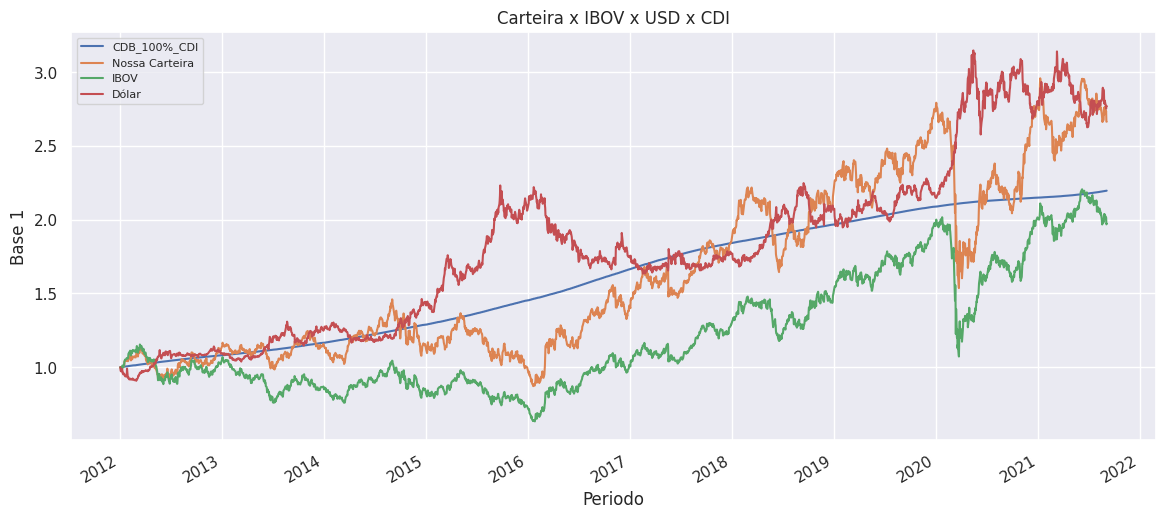

In [48]:
PL_normalizado[['CDB_100%_CDI', 'Nossa Carteira', 'IBOV', 'Dólar']].plot(figsize = (14,6));
# PL_normalizado
plt.legend(loc = 2, fontsize = 8)
plt.xlabel('Periodo')
# plt.ylabel('Considera aplicação de R$ 1.000,00')
plt.ylabel('Base 1')
plt.title('Carteira x IBOV x USD x CDI')
plt.show

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

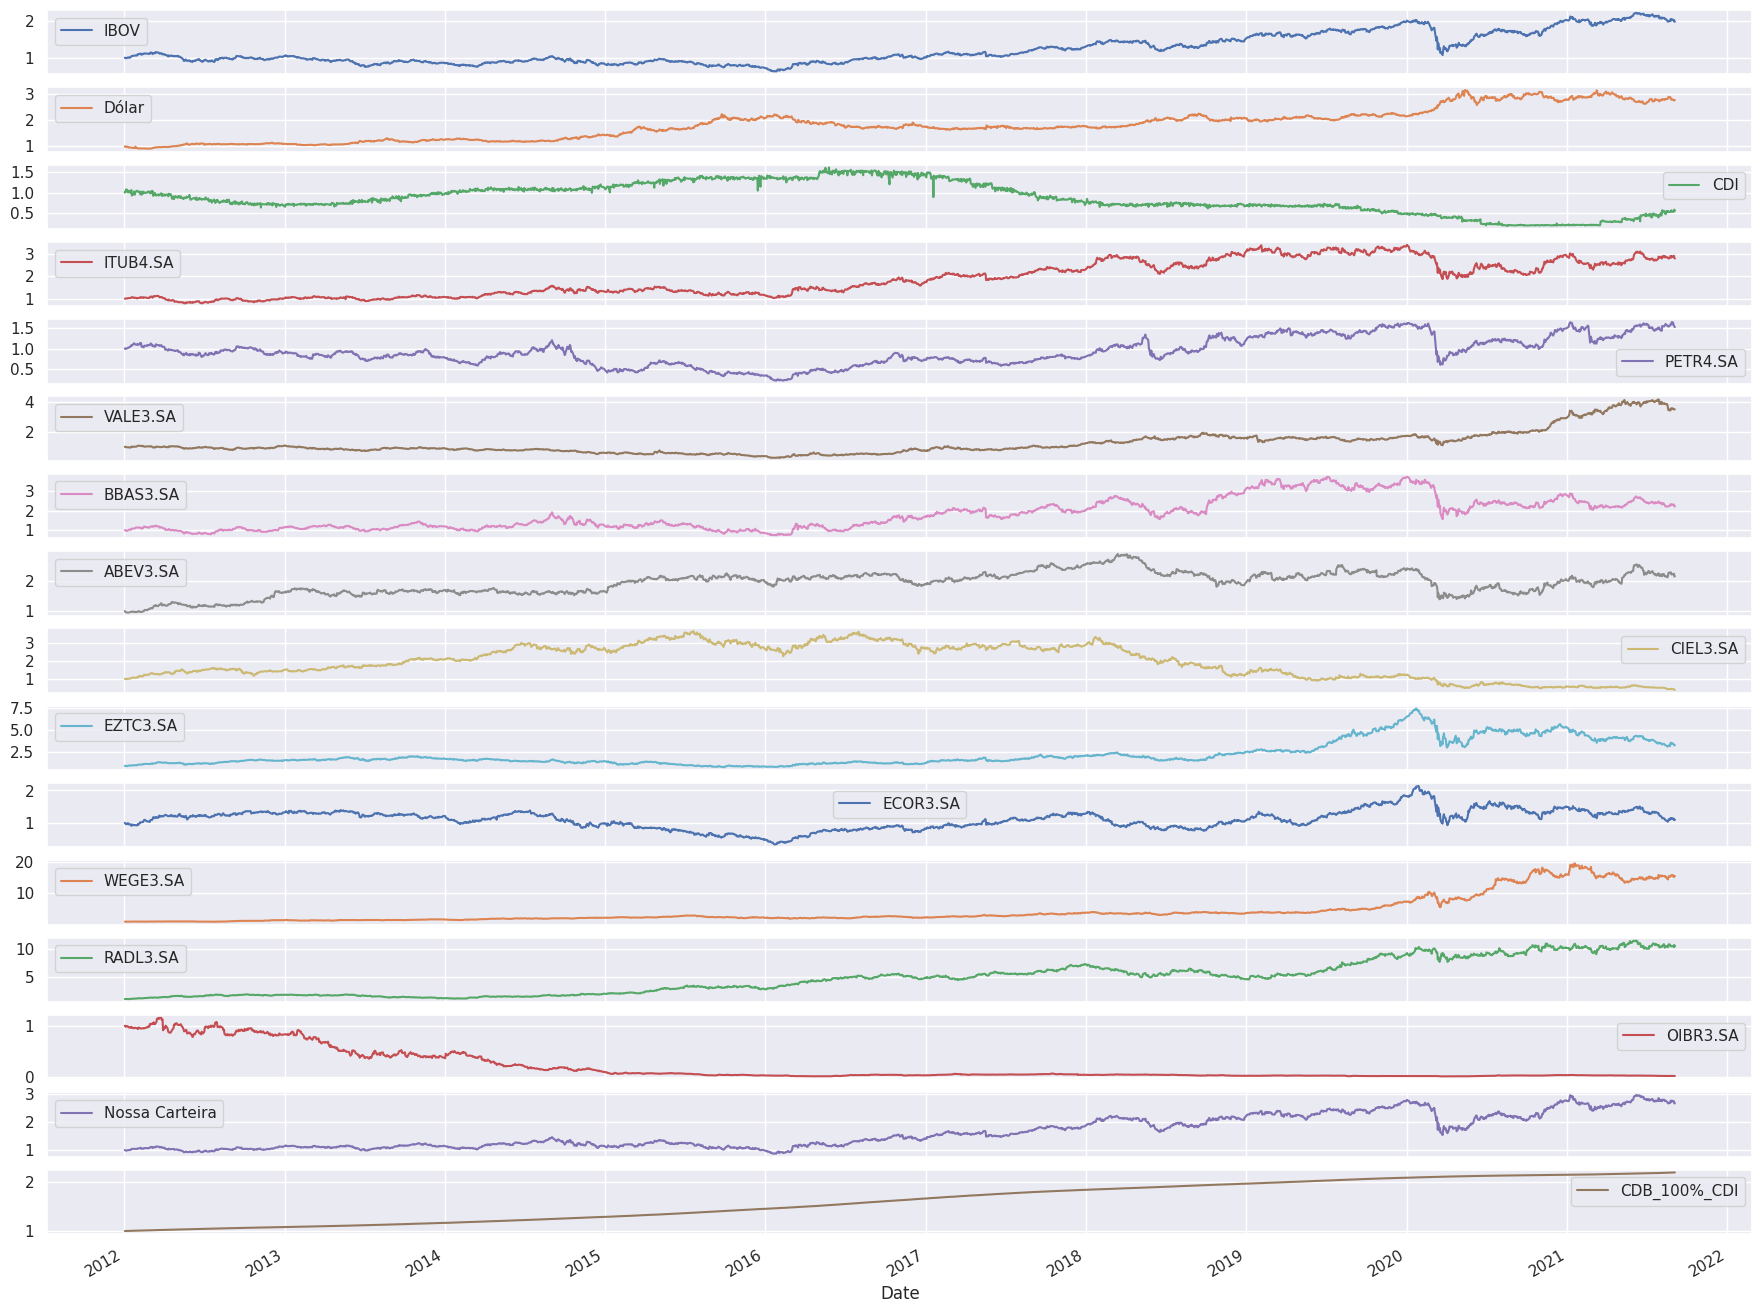

In [47]:
  PL_normalizado.plot(subplots=True, figsize=(22,18))